# 4-Spin Ising Model: Quench Dynamics

This notebook simulates the quench dynamics of a 4-spin Ising model with transverse field. We'll analyze:
- Magnetization evolution
- Energy dynamics
- Spin-spin correlations
- Order parameter relaxation

## Model
The Hamiltonian is:
$$H = -J \sum_{\langle i,j \rangle} \sigma_i^z \sigma_j^z - h \sum_i \sigma_i^x$$

Where:
- $J$ is the coupling strength
- $h$ is the transverse field
- We use periodic boundary conditions (ring topology)




In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm, eigh
from scipy.sparse import kron, eye, csr_matrix
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("Imports successful!")


Imports successful!


## 1. Define Pauli Matrices and Operators


In [2]:
# Pauli matrices
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
sigma_y = np.array([[0, -1j], [1j, 0]], dtype=complex)
sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)
identity = np.eye(2, dtype=complex)

N_spins = 4
dim = 2**N_spins  # Hilbert space dimension

print(f"System size: {N_spins} spins")
print(f"Hilbert space dimension: {dim}")


System size: 4 spins
Hilbert space dimension: 16


In [3]:
def single_site_operator(site, pauli_matrix, N):
    """
    Construct operator acting on a single site in the full Hilbert space.
    
    Parameters:
    -----------
    site : int
        Site index (0 to N-1)
    pauli_matrix : array
        Pauli matrix to apply
    N : int
        Number of spins
    """
    op_list = [identity] * N
    op_list[site] = pauli_matrix
    
    result = op_list[0]
    for i in range(1, N):
        result = np.kron(result, op_list[i])
    
    return result

def two_site_operator(site1, site2, pauli1, pauli2, N):
    """
    Construct operator acting on two sites in the full Hilbert space.
    
    Parameters:
    -----------
    site1, site2 : int
        Site indices
    pauli1, pauli2 : array
        Pauli matrices to apply
    N : int
        Number of spins
    """
    op_list = [identity] * N
    op_list[site1] = pauli1
    op_list[site2] = pauli2
    
    result = op_list[0]
    for i in range(1, N):
        result = np.kron(result, op_list[i])
    
    return result

print("Operator construction functions defined!")


Operator construction functions defined!


## 2. Construct the Ising Hamiltonian


In [4]:
def build_ising_hamiltonian(J, h, N, boundary='periodic'):
    """
    Build the transverse field Ising model Hamiltonian.
    
    H = -J Σ σ_i^z σ_{i+1}^z - h Σ σ_i^x
    
    Parameters:
    -----------
    J : float
        Coupling strength
    h : float
        Transverse field strength
    N : int
        Number of spins
    boundary : str
        'periodic' or 'open' boundary conditions
    """
    H = np.zeros((2**N, 2**N), dtype=complex)
    
    # Nearest-neighbor ZZ interaction
    for i in range(N-1):
        H += -J * two_site_operator(i, i+1, sigma_z, sigma_z, N)
    
    # Periodic boundary condition
    if boundary == 'periodic':
        H += -J * two_site_operator(N-1, 0, sigma_z, sigma_z, N)
    
    # Transverse field
    for i in range(N):
        H += -h * single_site_operator(i, sigma_x, N)
    
    return H

# Test with example parameters
J_test = 1.0
h_test = 0.5
H_test = build_ising_hamiltonian(J_test, h_test, N_spins)

print(f"Hamiltonian constructed!")
print(f"Shape: {H_test.shape}")
print(f"Is Hermitian: {np.allclose(H_test, H_test.conj().T)}")


Hamiltonian constructed!
Shape: (16, 16)
Is Hermitian: True


## 3. Initial State Preparation

We'll prepare the ground state of the initial Hamiltonian (before the quench).


In [5]:
def get_ground_state(H):
    """
    Get the ground state of a Hamiltonian.
    
    Parameters:
    -----------
    H : array
        Hamiltonian matrix
    
    Returns:
    --------
    E0 : float
        Ground state energy
    psi0 : array
        Ground state wavefunction
    """
    eigenvalues, eigenvectors = eigh(H)
    E0 = eigenvalues[0]
    psi0 = eigenvectors[:, 0]
    
    return E0, psi0

# Get ground state for test Hamiltonian
E0, psi0 = get_ground_state(H_test)
print(f"Ground state energy: {E0:.4f}")
print(f"Ground state norm: {np.linalg.norm(psi0):.4f}")


Ground state energy: -4.2716
Ground state norm: 1.0000


## 4. Time Evolution

Implement exact time evolution using $|\psi(t)\rangle = e^{-iHt}|\psi(0)\rangle$


In [6]:
def time_evolve(psi0, H, times):
    """
    Evolve a state in time under Hamiltonian H.
    
    Parameters:
    -----------
    psi0 : array
        Initial state
    H : array
        Hamiltonian
    times : array
        Time points
    
    Returns:
    --------
    psi_t : array
        State at each time point (shape: len(times) x dim)
    """
    # Diagonalize Hamiltonian for efficient evolution
    eigenvalues, eigenvectors = eigh(H)
    
    # Express initial state in energy eigenbasis
    coeffs = eigenvectors.conj().T @ psi0
    
    # Time evolution
    psi_t = np.zeros((len(times), len(psi0)), dtype=complex)
    
    for i, t in enumerate(times):
        # Apply time evolution in eigenbasis
        evolved_coeffs = coeffs * np.exp(-1j * eigenvalues * t)
        # Transform back to computational basis
        psi_t[i] = eigenvectors @ evolved_coeffs
    
    return psi_t

print("Time evolution function defined!")


Time evolution function defined!


## 5. Observable Calculations

Define functions to calculate relevant observables.


In [7]:
def compute_magnetization(psi, N, direction='z'):
    """
    Compute total magnetization in a given direction.
    
    M = (1/N) Σ_i ⟨σ_i^direction⟩
    """
    if direction == 'z':
        pauli = sigma_z
    elif direction == 'x':
        pauli = sigma_x
    elif direction == 'y':
        pauli = sigma_y
    else:
        raise ValueError("Direction must be 'x', 'y', or 'z'")
    
    mag = 0.0
    for i in range(N):
        op = single_site_operator(i, pauli, N)
        mag += np.real(psi.conj() @ op @ psi)
    
    return mag / N

def compute_site_magnetization(psi, N, direction='z'):
    """
    Compute magnetization at each site.
    """
    if direction == 'z':
        pauli = sigma_z
    elif direction == 'x':
        pauli = sigma_x
    elif direction == 'y':
        pauli = sigma_y
    
    mags = np.zeros(N)
    for i in range(N):
        op = single_site_operator(i, pauli, N)
        mags[i] = np.real(psi.conj() @ op @ psi)
    
    return mags

def compute_energy(psi, H):
    """
    Compute energy expectation value.
    """
    return np.real(psi.conj() @ H @ psi)

def compute_correlation(psi, site1, site2, N, direction='z'):
    """
    Compute two-point correlation function.
    
    C = ⟨σ_i^direction σ_j^direction⟩
    """
    if direction == 'z':
        pauli = sigma_z
    elif direction == 'x':
        pauli = sigma_x
    elif direction == 'y':
        pauli = sigma_y
    
    op = two_site_operator(site1, site2, pauli, pauli, N)
    return np.real(psi.conj() @ op @ psi)

def compute_all_correlations(psi, N, direction='z'):
    """
    Compute all pairwise correlations.
    """
    corr_matrix = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            if i == j:
                # Single-site expectation
                corr_matrix[i, j] = compute_magnetization(psi, N, direction) * N / N
            else:
                corr_matrix[i, j] = compute_correlation(psi, i, j, N, direction)
    
    return corr_matrix

print("Observable calculation functions defined!")


Observable calculation functions defined!


## 6. Perform Quench Dynamics Simulation

We'll simulate a quantum quench:
1. Start with ground state of initial Hamiltonian (large transverse field)
2. Suddenly change to final Hamiltonian (smaller transverse field)
3. Evolve under final Hamiltonian and track observables


In [8]:
# Quench parameters
J = 1.0                    # Coupling strength
h_initial = 3.0            # Initial transverse field (large - paramagnetic phase)
h_final = 0.5              # Final transverse field (smaller - closer to ferromagnetic phase)

# Build Hamiltonians
H_initial = build_ising_hamiltonian(J, h_initial, N_spins)
H_final = build_ising_hamiltonian(J, h_final, N_spins)

# Get initial ground state
E0_initial, psi_initial = get_ground_state(H_initial)

print(f"Initial Hamiltonian: J={J}, h={h_initial}")
print(f"Initial ground state energy: {E0_initial:.4f}")
print(f"Initial magnetization (z): {compute_magnetization(psi_initial, N_spins, 'z'):.4f}")
print(f"Initial magnetization (x): {compute_magnetization(psi_initial, N_spins, 'x'):.4f}")
print(f"\nFinal Hamiltonian: J={J}, h={h_final}")
E0_final, psi_final_gs = get_ground_state(H_final)
print(f"Final ground state energy: {E0_final:.4f}")
print(f"Final ground state magnetization (z): {compute_magnetization(psi_final_gs, N_spins, 'z'):.4f}")


Initial Hamiltonian: J=1.0, h=3.0
Initial ground state energy: -12.3468
Initial magnetization (z): -0.0000
Initial magnetization (x): 0.9689

Final Hamiltonian: J=1.0, h=0.5
Final ground state energy: -4.2716
Final ground state magnetization (z): 0.0000


In [9]:
# Time evolution after quench
t_max = 20.0
n_points = 200
times = np.linspace(0, t_max, n_points)

print("Performing time evolution...")
psi_t = time_evolve(psi_initial, H_final, times)
print("Time evolution complete!")


Performing time evolution...
Time evolution complete!


In [10]:
# Calculate observables at each time
print("Computing observables...")

magnetization_z = np.array([compute_magnetization(psi_t[i], N_spins, 'z') for i in range(len(times))])
magnetization_x = np.array([compute_magnetization(psi_t[i], N_spins, 'x') for i in range(len(times))])
energies = np.array([compute_energy(psi_t[i], H_final) for i in range(len(times))])

# Compute site-resolved magnetization
site_mags_z = np.array([compute_site_magnetization(psi_t[i], N_spins, 'z') for i in range(len(times))])
site_mags_x = np.array([compute_site_magnetization(psi_t[i], N_spins, 'x') for i in range(len(times))])

# Compute nearest-neighbor correlations
nn_correlations = np.array([compute_correlation(psi_t[i], 0, 1, N_spins, 'z') for i in range(len(times))])

print("Observables computed!")


Computing observables...
Observables computed!


## 7. Visualize Results


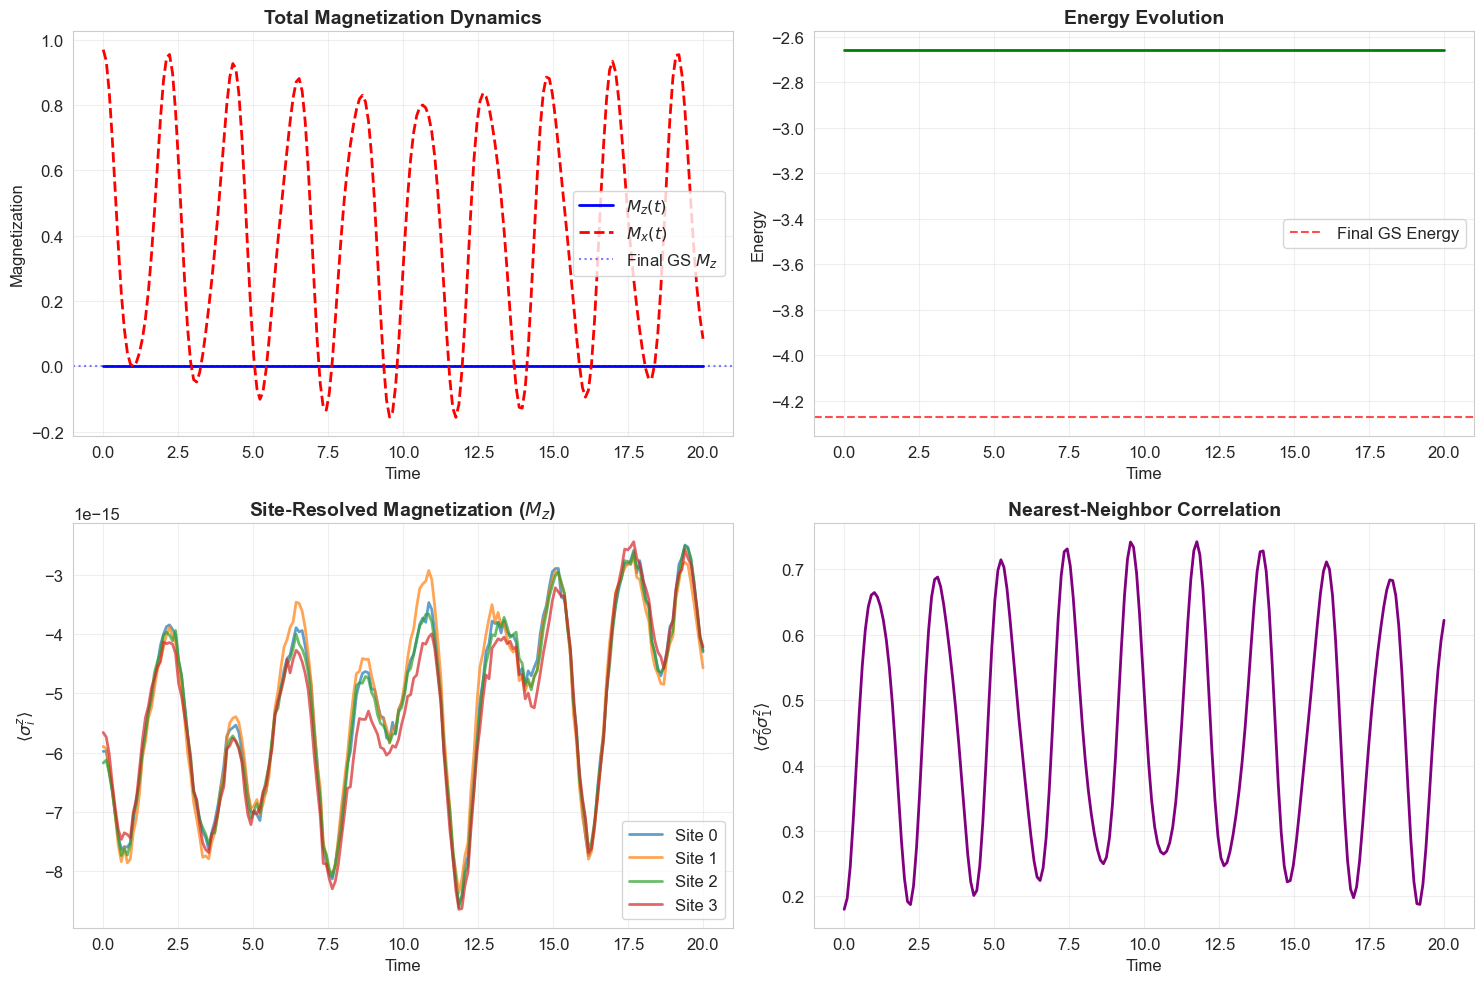

\nVisualization complete!


In [11]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Magnetization dynamics (z and x components)
ax = axes[0, 0]
ax.plot(times, magnetization_z, 'b-', linewidth=2, label=r'$M_z(t)$')
ax.plot(times, magnetization_x, 'r--', linewidth=2, label=r'$M_x(t)$')
ax.axhline(compute_magnetization(psi_final_gs, N_spins, 'z'), 
           color='blue', linestyle=':', alpha=0.5, label='Final GS $M_z$')
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Magnetization', fontsize=12)
ax.set_title('Total Magnetization Dynamics', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Energy dynamics
ax = axes[0, 1]
ax.plot(times, energies, 'g-', linewidth=2)
ax.axhline(E0_final, color='red', linestyle='--', alpha=0.7, label='Final GS Energy')
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Energy', fontsize=12)
ax.set_title('Energy Evolution', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Site-resolved magnetization
ax = axes[1, 0]
for i in range(N_spins):
    ax.plot(times, site_mags_z[:, i], linewidth=2, label=f'Site {i}', alpha=0.7)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel(r'$\langle \sigma_i^z \rangle$', fontsize=12)
ax.set_title('Site-Resolved Magnetization ($M_z$)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Nearest-neighbor correlations
ax = axes[1, 1]
ax.plot(times, nn_correlations, 'purple', linewidth=2)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel(r'$\langle \sigma_0^z \sigma_1^z \rangle$', fontsize=12)
ax.set_title('Nearest-Neighbor Correlation', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\\nVisualization complete!")


## 8. Additional Analysis: Correlation Matrix Evolution


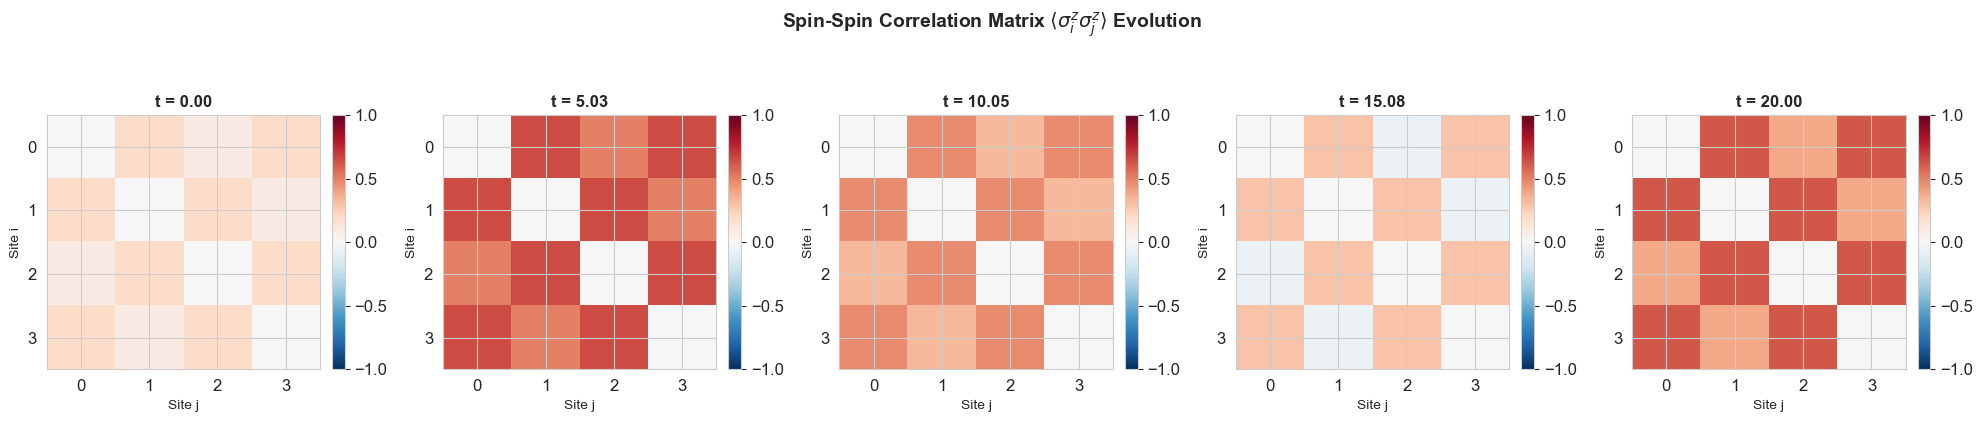

In [12]:
# Compute correlation matrices at different times
time_snapshots = [0, int(n_points*0.25), int(n_points*0.5), int(n_points*0.75), n_points-1]
time_values = [times[i] for i in time_snapshots]

fig, axes = plt.subplots(1, len(time_snapshots), figsize=(20, 4))

for idx, (t_idx, t_val) in enumerate(zip(time_snapshots, time_values)):
    corr_matrix = compute_all_correlations(psi_t[t_idx], N_spins, 'z')
    
    im = axes[idx].imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
    axes[idx].set_title(f't = {t_val:.2f}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Site j', fontsize=10)
    axes[idx].set_ylabel('Site i', fontsize=10)
    axes[idx].set_xticks(range(N_spins))
    axes[idx].set_yticks(range(N_spins))
    
    # Add colorbar
    plt.colorbar(im, ax=axes[idx], fraction=0.046, pad=0.04)

plt.suptitle(r'Spin-Spin Correlation Matrix $\langle \sigma_i^z \sigma_j^z \rangle$ Evolution', 
             fontsize=14, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()


## 9. Order Parameter and Relaxation Analysis


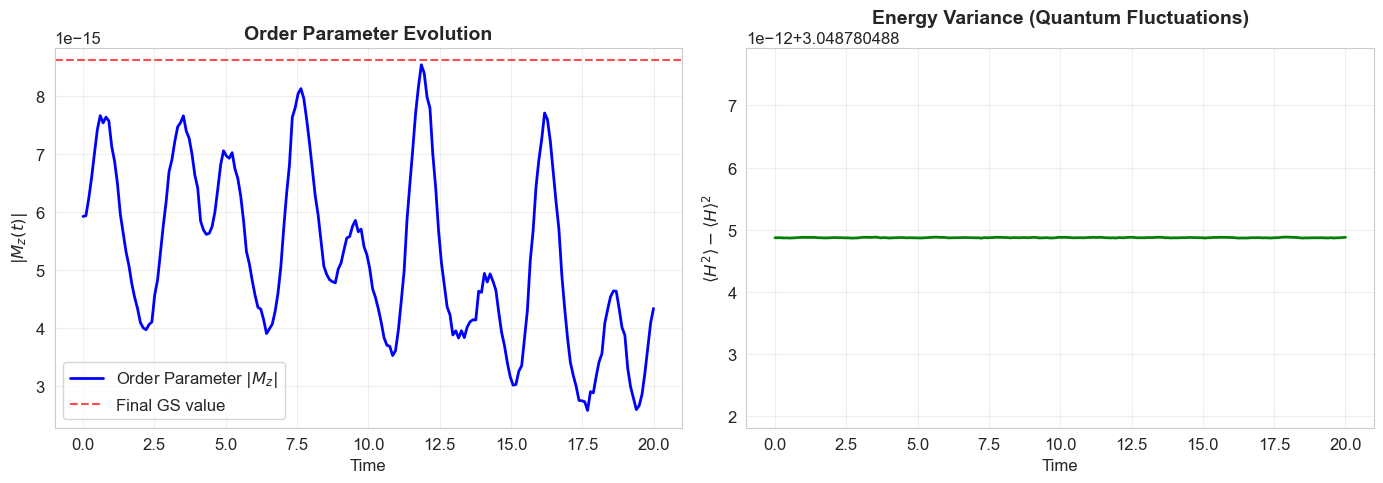

In [13]:
# Compute order parameter (absolute magnetization)
order_parameter = np.abs(magnetization_z)

# Compute energy variance (measure of quantum fluctuations)
# Using H^2 operator
H_final_squared = H_final @ H_final
energy_squared = np.array([np.real(psi_t[i].conj() @ H_final_squared @ psi_t[i]) 
                            for i in range(len(times))])
energy_variance = energy_squared - energies**2

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Order parameter
ax = axes[0]
ax.plot(times, order_parameter, 'b-', linewidth=2, label='Order Parameter $|M_z|$')
ax.axhline(np.abs(compute_magnetization(psi_final_gs, N_spins, 'z')), 
           color='red', linestyle='--', alpha=0.7, label='Final GS value')
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel(r'$|M_z(t)|$', fontsize=12)
ax.set_title('Order Parameter Evolution', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Energy variance
ax = axes[1]
ax.plot(times, energy_variance, 'g-', linewidth=2)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel(r'$\langle H^2 \rangle - \langle H \rangle^2$', fontsize=12)
ax.set_title('Energy Variance (Quantum Fluctuations)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 10. Summary Statistics


In [16]:
print("="*60)
print("QUENCH DYNAMICS SUMMARY")
print("="*60)
print(f"\nSystem Parameters:")
print(f"  Number of spins: {N_spins}")
print(f"  Coupling J: {J}")
print(f"  Initial field h_i: {h_initial}")
print(f"  Final field h_f: {h_final}")
print(f"\nInitial State (t=0):")
print(f"  Energy: {energies[0]:.4f}")
print(f"  Magnetization M_z: {magnetization_z[0]:.4f}")
print(f"  Magnetization M_x: {magnetization_x[0]:.4f}")
print(f"  NN Correlation: {nn_correlations[0]:.4f}")
print(f"\nFinal State (t={t_max}):")
print(f"  Energy: {energies[-1]:.4f}")
print(f"  Magnetization M_z: {magnetization_z[-1]:.4f}")
print(f"  Magnetization M_x: {magnetization_x[-1]:.4f}")
print(f"  NN Correlation: {nn_correlations[-1]:.4f}")
print(f"\nTarget Ground State:")
print(f"  Energy: {E0_final:.4f}")
print(f"  Magnetization M_z: {compute_magnetization(psi_final_gs, N_spins, 'z'):.4f}")
print(f"\nDynamics Statistics:")
print(f"  Max |M_z|: {np.max(np.abs(magnetization_z)):.4f}")
print(f"  Min |M_z|: {np.min(np.abs(magnetization_z)):.4f}")
print(f"  Mean energy: {np.mean(energies):.4f}")
print(f"  Energy conservation check: {np.std(energies):.6f}")
print("="*60)


QUENCH DYNAMICS SUMMARY

System Parameters:
  Number of spins: 4
  Coupling J: 1.0
  Initial field h_i: 3.0
  Final field h_f: 0.5

Initial State (t=0):
  Energy: -2.6574
  Magnetization M_z: -0.0000
  Magnetization M_x: 0.9689
  NN Correlation: 0.1799

Final State (t=20.0):
  Energy: -2.6574
  Magnetization M_z: -0.0000
  Magnetization M_x: 0.0841
  NN Correlation: 0.6223

Target Ground State:
  Energy: -4.2716
  Magnetization M_z: 0.0000

Dynamics Statistics:
  Max |M_z|: 0.0000
  Min |M_z|: 0.0000
  Mean energy: -2.6574
  Energy conservation check: 0.000000


## 11. Experiment with Different Quench Parameters

Feel free to modify the parameters below to explore different quench scenarios:


Running comparison of different quench depths...


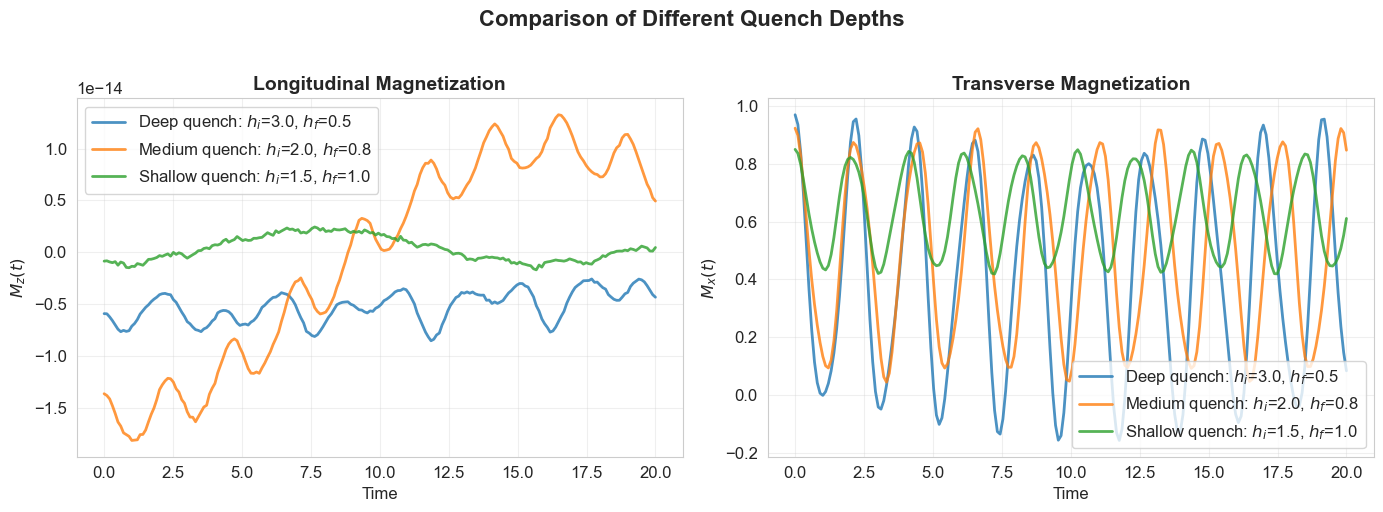

Comparison complete!


In [17]:
def run_quench_experiment(J, h_i, h_f, t_max=20.0, n_points=200):
    """
    Run a complete quench experiment with given parameters.
    
    Parameters:
    -----------
    J : float
        Coupling strength
    h_i : float
        Initial transverse field
    h_f : float
        Final transverse field
    t_max : float
        Maximum evolution time
    n_points : int
        Number of time points
    """
    # Build Hamiltonians
    H_i = build_ising_hamiltonian(J, h_i, N_spins)
    H_f = build_ising_hamiltonian(J, h_f, N_spins)
    
    # Get initial state
    _, psi_i = get_ground_state(H_i)
    
    # Time evolution
    times = np.linspace(0, t_max, n_points)
    psi_t = time_evolve(psi_i, H_f, times)
    
    # Compute observables
    mag_z = np.array([compute_magnetization(psi_t[i], N_spins, 'z') for i in range(n_points)])
    mag_x = np.array([compute_magnetization(psi_t[i], N_spins, 'x') for i in range(n_points)])
    
    return times, mag_z, mag_x

# Example: Compare different quench depths
print("Running comparison of different quench depths...")
quench_scenarios = [
    (1.0, 3.0, 0.5, 'Deep quench'),
    (1.0, 2.0, 0.8, 'Medium quench'),
    (1.0, 1.5, 1.0, 'Shallow quench'),
]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for J, h_i, h_f, label in quench_scenarios:
    times, mag_z, mag_x = run_quench_experiment(J, h_i, h_f)
    axes[0].plot(times, mag_z, linewidth=2, label=f'{label}: $h_i$={h_i}, $h_f$={h_f}', alpha=0.8)
    axes[1].plot(times, mag_x, linewidth=2, label=f'{label}: $h_i$={h_i}, $h_f$={h_f}', alpha=0.8)

axes[0].set_xlabel('Time', fontsize=12)
axes[0].set_ylabel(r'$M_z(t)$', fontsize=12)
axes[0].set_title('Longitudinal Magnetization', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('Time', fontsize=12)
axes[1].set_ylabel(r'$M_x(t)$', fontsize=12)
axes[1].set_title('Transverse Magnetization', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('Comparison of Different Quench Depths', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("Comparison complete!")


## Notes and Future Directions

### Key Physics Observations:
1. **Quantum Quench**: The system starts in the ground state of one Hamiltonian and suddenly evolves under a different one
2. **Non-equilibrium Dynamics**: The magnetization oscillates and doesn't immediately reach the new ground state
3. **Energy Conservation**: The energy should be conserved during unitary evolution (check std)
4. **Correlation Spreading**: Spin-spin correlations evolve and spread through the chain

### Interesting Phenomena to Explore:
- **Thermalization**: Does the system eventually reach thermal equilibrium?
- **Quantum Revivals**: Periodic returns to initial state (more visible in smaller systems)
- **Critical Quenches**: Quenching to/from the critical point (h/J ≈ 1)
- **Kibble-Zurek Mechanism**: Slow quenches across phase transitions
- **Loschmidt Echo**: Overlap with initial state as function of time

### Extensions:
- Increase system size (but note exponential scaling!)
- Add long-range interactions
- Include disorder (Anderson localization)
- Study entanglement entropy evolution
- Compare with sudden vs. slow quenches (ramp protocols)
